# Линейная регрессия для предсказания цен

In [332]:
import numpy as np 
import pandas as pd
from math import sqrt
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [333]:
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

# Анализ данных

Загрузка датасетов

In [334]:

train = pd.DataFrame(pd.read_csv('C:/Users/Лавандос/Downloads/train.csv'))
test = pd.DataFrame(pd.read_csv('C:/Users/Лавандос/Downloads/test.csv'))

In [335]:
#проверка
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [336]:
# смотрим на количество записей/колонок
print('No. of records in train dataset: ', len(train.index))
print('No. of columns in train dataset: ', len(train.columns))
print('No. of records in test dataset: ', len(test.index))
print('No. of columns in test dataset: ', len(test.columns))

No. of records in train dataset:  1460
No. of columns in train dataset:  81
No. of records in test dataset:  1459
No. of columns in test dataset:  80


In [337]:
#Узнаем сколько пропущенных значений
print ('Total missing values in train set', sum(train.isna().sum()))
print ('Total missing values in test set', sum(test.isna().sum()))

Total missing values in train set 6965
Total missing values in test set 7000


Посмотрим на значения, которые принимает наш таргет

In [338]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:>

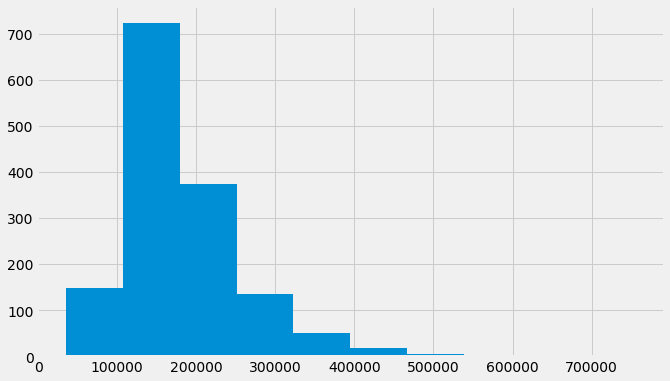

In [339]:
train['SalePrice'].hist()

Посмотрим на фичи, которые больше всего / меньше всего корр. с нашим таргетом

In [340]:
numeric_cols = train.select_dtypes(include = [np.number])
corr = numeric_cols.corr()
print ('The Most Correlated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[:10], '\n')
print ('The Most Uncorrelated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[-5:])

The Most Correlated Features with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

The Most Uncorrelated Features with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


(None, None)

Посмотрим на наиболее корр. признаки и уберём выбросы, которые могут вносить неточности

Text(0.5, 0, 'GrLivArea')

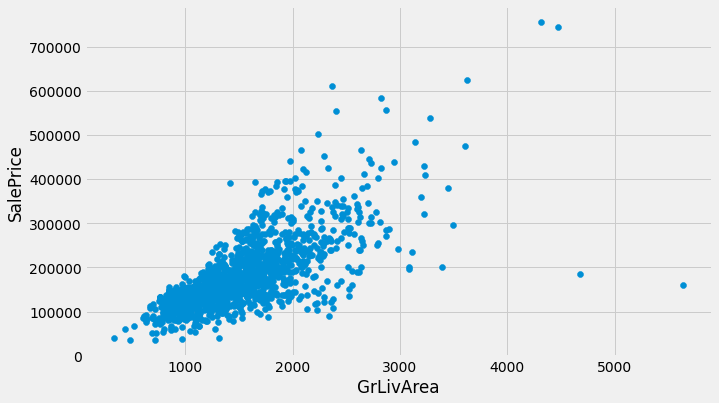

In [341]:
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')

Видны выбросы начиная с 4500

Text(0.5, 0, 'GarageArea')

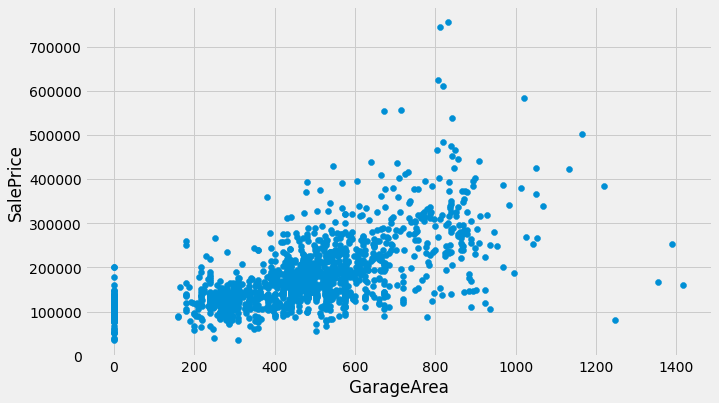

In [342]:
plt.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

Видно, что большинство домов без гаража, а также некоторые выбросы (>=1200)

# Подготовка данных

In [343]:
# удаляем выбросы в GrLivArea
train = train[train['GrLivArea'] < 4500]

In [344]:
# удаляем выбросы в GarageArea
train = train[train['GarageArea'] < 1200]

In [345]:
# удаляем колонки с процентом пропущенных значений > 80%
train_percentage = train.isnull().sum() / train.shape[0]
print (train_percentage[train_percentage > 0.80])
train = train.drop(train_percentage[train_percentage > 0.80].index, axis = 1)

Alley          0.937414
PoolQC         0.995873
Fence          0.806740
MiscFeature    0.963549
dtype: float64


In [346]:
# аналогично для тестового датасета
test_percentage = test.isnull().sum() / test.shape[0]
print (test_percentage[test_percentage > 0.80])
test = test.drop(test_percentage[test_percentage > 0.80].index, axis = 1)

Alley          0.926662
PoolQC         0.997944
Fence          0.801234
MiscFeature    0.965045
dtype: float64


In [347]:
# обработка признаков категории
le = preprocessing.LabelEncoder()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

In [348]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,...,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,...,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,3,0,4,...,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,3,0,0,...,272,0,0,0,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,3,0,2,...,0,0,0,0,0,12,2008,8,4,250000


In [349]:
# аналогично для тестового датасета
for name in test.columns:
    if test[name].dtypes == 'O':
        test[name] = test[name].astype(str)
        le.fit(test[name])
        test[name] = le.transform(test[name])

In [350]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,2,80.0,11622,1,3,3,0,4,...,0,0,0,120,0,0,6,2010,8,4
1,1462,20,3,81.0,14267,1,0,3,0,0,...,36,0,0,0,0,12500,6,2010,8,4
2,1463,60,3,74.0,13830,1,0,3,0,4,...,34,0,0,0,0,0,3,2010,8,4
3,1464,60,3,78.0,9978,1,0,3,0,4,...,36,0,0,0,0,0,6,2010,8,4
4,1465,120,3,43.0,5005,1,0,1,0,4,...,82,0,0,144,0,0,1,2010,8,4


Заполнение пропущенных данных будем делать на основе вероятности появления в датасете, в последствии проведём логарифмированние, чтобы нормализовать данные, таким образом избавившись от некоторого числа ошибок при обучении модели

In [351]:
# заполняем данные на основе вероятности появления
for column in train.columns:
    null_vals = train.isnull().values
    a, b = np.unique(train.values[~null_vals], return_counts = 1)
    train.loc[train[column].isna(), column] = np.random.choice(a, train[column].isnull().sum(), p = b / b.sum())

In [352]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60.0,3.0,65.0,8450.0,1.0,3.0,3.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,8.0,4.0,208500.0
1,2.0,20.0,3.0,80.0,9600.0,1.0,3.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,8.0,4.0,181500.0
2,3.0,60.0,3.0,68.0,11250.0,1.0,0.0,3.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,8.0,4.0,223500.0
3,4.0,70.0,3.0,60.0,9550.0,1.0,0.0,3.0,0.0,0.0,...,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,8.0,0.0,140000.0
4,5.0,60.0,3.0,84.0,14260.0,1.0,0.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,8.0,4.0,250000.0


In [353]:
# применяем логарифмирование для того, чтобы уменьшить скошенность распределения
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

In [354]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,4.110874,3.0,4.189655,9.042040,1.0,3.0,3.0,0.0,4.0,...,0.000000,0.0,0.0,0.0,0.0,2.0,2008.0,8.0,4.0,12.247699
1,2.0,3.044522,3.0,4.394449,9.169623,1.0,3.0,3.0,0.0,2.0,...,0.000000,0.0,0.0,0.0,0.0,5.0,2007.0,8.0,4.0,12.109016
2,3.0,4.110874,3.0,4.234107,9.328212,1.0,0.0,3.0,0.0,4.0,...,0.000000,0.0,0.0,0.0,0.0,9.0,2008.0,8.0,4.0,12.317171
3,4.0,4.262680,3.0,4.110874,9.164401,1.0,0.0,3.0,0.0,0.0,...,5.609472,0.0,0.0,0.0,0.0,2.0,2006.0,8.0,0.0,11.849405
4,5.0,4.110874,3.0,4.442651,9.565284,1.0,0.0,3.0,0.0,2.0,...,0.000000,0.0,0.0,0.0,0.0,12.0,2008.0,8.0,4.0,12.429220


In [355]:
# аналогично для тестового
skewed_test = test.apply(lambda x: skew(x.dropna()))
skewed_test = skewed_test[skewed_test > .75]
test[skewed_test.index] = np.log1p(test[skewed_test.index])

In [356]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,3.044522,2,80.0,9.360741,1,3,3,0.0,4,...,0.000000,0.0,0.0,4.795791,0.0,0.000000,6,2010,8,4
1,1462,3.044522,3,81.0,9.565775,1,0,3,0.0,0,...,3.610918,0.0,0.0,0.000000,0.0,9.433564,6,2010,8,4
2,1463,4.110874,3,74.0,9.534668,1,0,3,0.0,4,...,3.555348,0.0,0.0,0.000000,0.0,0.000000,3,2010,8,4
3,1464,4.110874,3,78.0,9.208238,1,0,3,0.0,4,...,3.610918,0.0,0.0,0.000000,0.0,0.000000,6,2010,8,4
4,1465,4.795791,3,43.0,8.518392,1,0,1,0.0,4,...,4.418841,0.0,0.0,4.976734,0.0,0.000000,1,2010,8,4


# Создание модели и предсказание цен

Дропаем таргет из обучающего датасета, запоминаем его в переменную. В конце просто разделяем 80:20 полученные данные для модели

In [357]:
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
lr = linear_model.LinearRegression()

Подаём данные для обучения

In [360]:
model = lr.fit(X_train, y_train)
# Пытаемся предсказать цены
predictions = model.predict(X_test)

**MAE**: Средняя абсолютная ошибка.<br>
**MSE**: Средняя квадратичная ошибка, полезна для отлова больших ошибок<br>
**RMSE**:Среднеквадратическая ошибка <br>

In [361]:
print ('MAE is:', mean_absolute_error(y_test, predictions))
print ('MSE is:', mean_squared_error(y_test, predictions))
print ('RMSE is:', sqrt(mean_squared_error(y_test, predictions)))
print ('R2 : ', r2_score (y_test, predictions) )

MAE is: 0.08784277789245745
MSE is: 0.01712084013973727
RMSE is: 0.1308466283086319
R2 :  0.9002098147651288


Text(0.5, 1.0, 'Linear Regression Model')

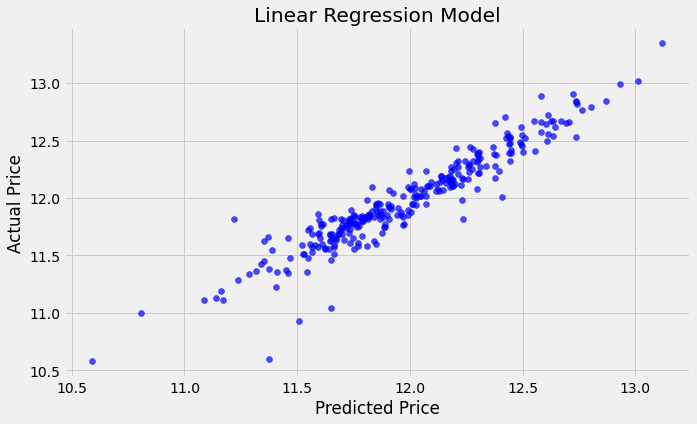

In [362]:
# задаём альфа, чтобы посмотреть совпадающие данные
plt.scatter(predictions, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')

# Вывод цен

In [363]:
#забираем идентификаторы
Ids = test['Id'] 
#копируем данные из теста, предварительно подготовив их для того, чтобы использовать как данные для предсказания.
temp = test.drop(['Id'], axis = 1).interpolate()

In [364]:
#предсказываем цены
predictions = model.predict(temp)
# Выводим данные и берём экспоненту, потому что пользовались логарифмированием
output = pd.DataFrame({'Id': Ids, 'SalePrice': np.exp(predictions)})
output.head()

,Id,SalePrice
0,1461,105026.708450
1,1462,125138.447349
2,1463,154233.028610
3,1464,163810.876684
4,1465,158050.037165
